In [308]:
import numpy as np
import pandas as pd
import collections
from pprint import pprint
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import f1_score

data = pd.read_csv("heart.csv")


header = ["Age", "Sex","cp","trtbps","chol","fbs", "restecg","thalachh","exng","oldpeak","slp","caa","thall","output"]
N = len(data)
test_data = []
train_data = []
# splitting the data in test and train by ratio of 1:3
for row in data.values:
    if N % 3 == 0:
        test_data.append(row)
    else:
        train_data.append(row)
    N -=1
test_data = pd.DataFrame(test_data,columns = header)
train_data = pd.DataFrame(train_data,columns = header)
test_data.head()


,Age,Sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
2,56.0,0.0,1.0,140.0,294.0,0.0,0.0,153.0,0.0,1.3,1.0,0.0,2.0,1.0
3,57.0,1.0,2.0,150.0,168.0,0.0,1.0,174.0,0.0,1.6,2.0,0.0,2.0,1.0
4,49.0,1.0,1.0,130.0,266.0,0.0,1.0,171.0,0.0,0.6,2.0,0.0,2.0,1.0


In [262]:
data.shape

(303, 14)

In [263]:
data.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [264]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    if isinstance(rows, list):
        N = len(rows)
#         rows = np.array(rows)
        rows = pd.DataFrame(rows,columns = header)
    for row in rows.values:
        # in our dataset format, the label is always the last column
        label = row[-1]
#         print(label)
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [265]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl ** 2
    return impurity


In [266]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)


In [267]:

def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)


In [268]:

class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value
    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))


In [310]:


def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows.values:
        # print("e",row)
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return pd.DataFrame(true_rows,columns = header), pd.DataFrame(false_rows,columns = header)



In [270]:

def find_best_split(rows):
    best_gain = 0
    values = []
    entropy = gini(rows)
    best_question = None
    n_features = len(rows.loc[0]) - 1
#     print(rows.loc[0],len(rows.loc[0]))
    for col in range(n_features):
        #         print(col)
        #         print(rows.loc[0][col])
        value = set()
        N = len(rows)
        for i in range(1, N):
            value.add(rows.iloc[i][col])
        #             print(value)
        for val in value:
            question = Question(col, val)
            #             print(question)
            #             print("r",rows)
            true_rows, false_rows = partition(rows, question)
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue
            gain = info_gain(true_rows, false_rows, entropy)
            if gain > best_gain:
                best_gain, best_question = gain, question
    return best_gain, best_question



In [296]:


class Leaf:
    def __init__(self, rows):
#         print(class_counts(rows))
        count = class_counts(rows)
        self.predictions = count


In [272]:
class DecisionNode:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch


In [273]:

def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")


In [291]:

def classify(rows, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(rows):
        return classify(rows, node.true_branch)
    else:
        return classify(rows, node.false_branch)


In [292]:

def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs


In [293]:
def build_tree(rows):
    # to get the best question and the best gain
    gain, question = find_best_split(rows)
    if gain == 0:
        return Leaf(rows)
    true_rows, false_rows = partition(rows, question)
    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)
    return DecisionNode(question, true_branch, false_branch)



In [306]:
if __name__ == '__main__':
    my_tree = build_tree(train_data)
    print_tree(my_tree)
#     print(test_data.head())
    actual = []
    predicted = []
    for row in test_data.values:
        actual.append(int(row[-1]))
        predic = classify(row, my_tree)
        for k,v in predic.items():
            predicted.append(int(k))
        print("Actual: %s. Predicted: %s" %(actual[-1],predicted[-1]))



Is cp >= 1.0?
--> True:
  Is Age >= 56.0?
  --> True:
    Is Sex >= 1.0?
    --> True:
      Is chol >= 246.0?
      --> True:
        Is trtbps >= 120.0?
        --> True:
          Is slp >= 1.0?
          --> True:
            Predict {0.0: 8}
          --> False:
            Predict {1.0: 1}
        --> False:
          Predict {1.0: 1}
      --> False:
        Is oldpeak >= 2.6?
        --> True:
          Predict {0.0: 3}
        --> False:
          Is chol >= 208.0?
          --> True:
            Is trtbps >= 152.0?
            --> True:
              Is trtbps >= 156.0?
              --> True:
                Predict {1.0: 3}
              --> False:
                Predict {0.0: 2}
            --> False:
              Predict {1.0: 10}
          --> False:
            Predict {0.0: 1}
    --> False:
      Is cp >= 2.0?
      --> True:
        Predict {1.0: 11}
      --> False:
        Is Age >= 58.0?
        --> True:
          Is chol >= 319.0?
          --> True:
         

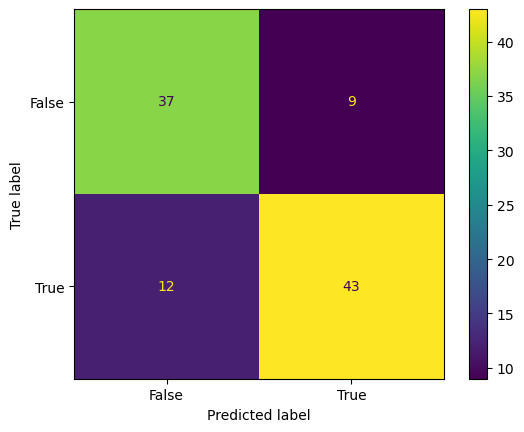

In [307]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [309]:
f1_score(actual,predicted)

0.8037383177570092